**项目简介**

本项目基于 TensorFlow 框架，在 Kaggle 平台实现一个简单的邮件分类器，用于判断短信是否为垃圾邮件（Spam）或正常邮件（Ham）。

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re

# sklearn 用于划分训练集和测试集
from sklearn.model_selection import train_test_split

# Tokenizer 用于将文本分词，pad_sequences 用于统一长度
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2025-06-09 00:15:18.768906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749428119.025323      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749428119.104009      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**读取数据**

加载数据：读取 spam.csv 并保留 'v1'（标签）和 'v2'（文本）。

标签处理：将 ham 映射为 0，spam 映射为 1。

In [2]:
# 从 Kaggle 数据集中读取 spam.csv 文件（路径可能根据数据集不同略有调整）
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']  # 重命名列

# 标签转换：ham -> 0, spam -> 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

**预处理文本**

文本清洗：小写化，移除非字母字符。

分词编码：使用 Tokenizer 将文本转化为数字序列。

序列填充：将所有序列填充或截断为等长（如100）。

划分训练集和测试集：使用 sklearn 的 train_test_split。

In [3]:
# 文本清洗：小写化、去除非字母字符
df['message'] = df['message'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x.lower()))

# 创建分词器，最多保留5000个词，未知词用<OOV>表示
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['message'])

# 将文本转为整数序列
sequences = tokenizer.texts_to_sequences(df['message'])

# 将所有序列统一为100词长度（多余截断，不足补零）
padded = pad_sequences(sequences, padding='post', maxlen=100)

# 标签转为 NumPy 数组
X = padded
y = df['label'].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**构建模型**

模型结构：
Embedding 层：将词汇表映射为稠密向量

GlobalAveragePooling1D：取平均值

Dense 层：中间隐藏层（24个神经元）

Dense 层：输出层（1个神经元，Sigmoid激活）

编译模型：损失函数为 binary_crossentropy，优化器使用 adam。

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 16),  # 词嵌入层：将词ID转为16维向量
    tf.keras.layers.GlobalAveragePooling1D(),  # 平均池化：将词向量合并为文本向量
    tf.keras.layers.Dense(24, activation='relu'),  # 全连接隐藏层，24个神经元
    tf.keras.layers.Dense(1, activation='sigmoid')  # 输出层，二分类概率输出
])

# 编译模型：使用交叉熵损失函数和Adam优化器
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 构建模型结构（让summary显示参数信息）
model.build(input_shape=(None, 100))
model.summary()

2025-06-09 00:15:37.263545: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 16)             │          80,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │             408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,433 (314.19 KB)

 Trainable params: 80,433 (314.19 KB)

 Non-trainable params: 0 (0.00 B)

**训练模型**

模型训练：训练 10 个 epoch，验证集为测试集。

评估模型：输出准确率与损失值。

In [5]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8338 - loss: 0.4240 - val_accuracy: 0.8655 - val_loss: 0.3718
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8724 - loss: 0.3543 - val_accuracy: 0.8655 - val_loss: 0.3605
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8558 - loss: 0.3669 - val_accuracy: 0.8655 - val_loss: 0.3367
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8570 - loss: 0.3295 - val_accuracy: 0.8655 - val_loss: 0.2734
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8867 - loss: 0.2277 - val_accuracy: 0.9318 - val_loss: 0.1654
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9623 - loss: 0.1222 - val_accuracy: 0.9677 - val_loss: 0.1085
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9781 - loss: 0.0813 - val_accuracy: 0.9776 - val_loss: 0.0880
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9834 - loss: 0.0565 - val_accuracy: 0.

**可视化准确率**

可视化训练过程：绘制 accuracy 随 epoch 的变化曲线。

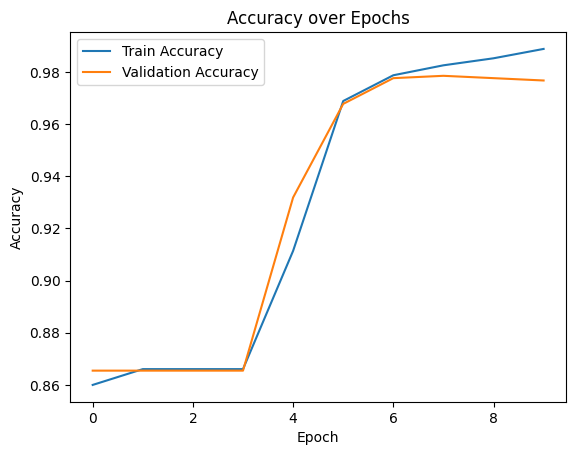

In [6]:
# 绘制训练和验证准确率变化图
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**保存模型**

In [7]:
model.save('/kaggle/working/spam_classifier.h5')
# 将模型保存为 .h5 文件，方便下载和部署